In [ ]:
pip install pandas numpy nltk textblob matplotlib seaborn

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     88751
           1       0.29      0.62      0.40      8591
           2       0.64      0.74      0.69     16348

    accuracy                           0.80    113690
   macro avg       0.63      0.73      0.66    113690
weighted avg       0.87      0.80      0.83    113690

Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90     88933
           1       0.29      0.62      0.40      8491
           2       0.65      0.73      0.69     16267

    accuracy                           0.80    113691
   macro avg       0.63      0.73      0.66    113691
weighted avg       0.87      0.80      0.83    113691


Sample P

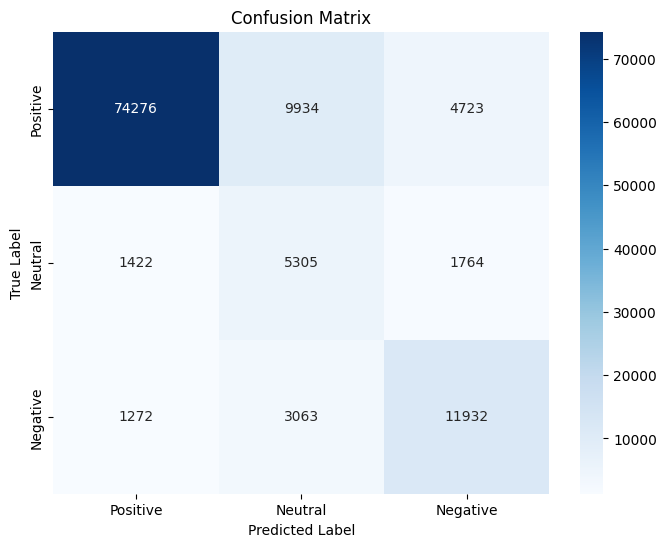

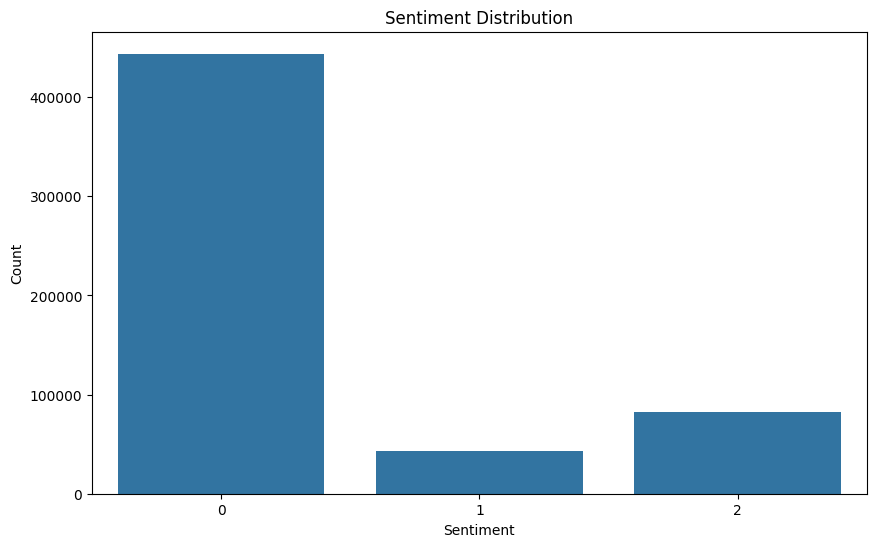

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/Reviews.csv')

# Check the columns
print(df.columns)

# Create a sentiment column based on the Score
def label_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['Score'].apply(label_sentiment)

# Map sentiment labels to numerical values
label_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}
df['sentiment'] = df['sentiment'].map(label_mapping)

# Split the dataset
X = df['Text']
y = df['sentiment']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Create a pipeline for model training
pipeline = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000))  # Logistic Regression
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__C': [0.1, 1, 10],  # Regularization parameter
    'classifier__solver': ['lbfgs', 'liblinear']  # Solvers to try
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_resampled, y_train_resampled)

# Evaluate the best model
best_model = grid_search.best_estimator_
X_val_tfidf = vectorizer.transform(X_val)
val_predictions = best_model.predict(X_val_tfidf)

# Validation
print('Validation Classification Report:')
print(classification_report(y_val, val_predictions))

# Evaluation on the test set
X_test_tfidf = vectorizer.transform(X_test)
test_predictions = best_model.predict(X_test_tfidf)
print('Test Classification Report:')
print(classification_report(y_test, test_predictions))

# Display predictions alongside true labels
results_df = pd.DataFrame({'True Label': y_test, 'Predicted Label': test_predictions})
print("\nSample Predictions:")
print(results_df.head(10))  # Display the first 10 predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Visualization of Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()